In [ ]:
import os
os.chdir("../")
%pwd

'/Users/hh/MLops/ajjil_technical_task'

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
items = pd.read_csv("artifacts/preprocessed_data/purchase-order-items.csv")
clusters = pd.read_csv("artifacts/categorisation/clusters.csv")
labels = pd.read_csv("artifacts/categorisation/cluster_labels.csv")

In [4]:
for df in (clusters, items):
    df['Item Name'] = df['Item Name'].astype(str).str.strip()

clusters_1row = (clusters
                 .sort_values('confidence')
                 .drop_duplicates('Item Name', keep='last')
                 [['Item Name','cluster_id','confidence']])

out = items.merge(clusters_1row, on='Item Name', how='left')
out = out.merge(labels[['cluster_id','label','top_terms']], on='cluster_id', how='left')
out['label'] = np.where(out['cluster_id'].isna() | (out['cluster_id'] == -1), 'Other', out['label'].fillna('Other'))
out['confidence'] = out['confidence'].fillna(0.0)


In [29]:
cat_spend = out.groupby("label")["Total Bcy"].sum().sort_values(ascending=False)
cat_spend_share = cat_spend / cat_spend.sum()


In [30]:
print(cat_spend.to_string(float_format='{:,.0f}'.format))

label
Rebar & Steel         48,787,757
Electrical & Cables   26,887,966
Other                 21,831,575
Pipes & Fittings      19,384,915
Hardware & Tools      17,964,761
Sheets & Plates       11,604,680
Cement & Concrete      5,968,120
Fasteners & Anchors    1,972,855
Paints & Coatings      1,730,024
PPE & Safety             470,703


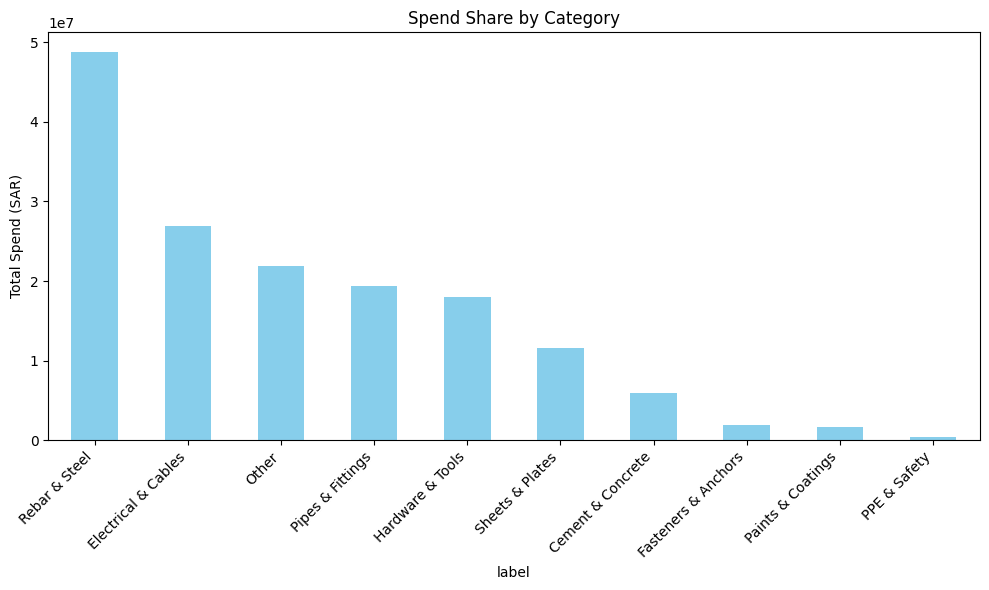

In [31]:
plt.figure(figsize=(10,6))
cat_spend.plot(kind="bar", color="skyblue")
plt.title("Spend Share by Category")
plt.ylabel("Total Spend (SAR)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [7]:
cat_spend_share

label
Rebar & Steel          0.311537
Electrical & Cables    0.171695
Other                  0.139407
Pipes & Fittings       0.123784
Hardware & Tools       0.114715
Sheets & Plates        0.074102
Cement & Concrete      0.038110
Fasteners & Anchors    0.012598
Paints & Coatings      0.011047
PPE & Safety           0.003006
Name: Total Bcy, dtype: float64

In [15]:
grp = out.groupby("label")["Unit Price"]
price_stats = grp.agg(["count", "mean", "std"])
price_stats["cv"] = price_stats["std"] / price_stats["mean"]
price_stats = price_stats.sort_values("cv")
print(price_stats.head(10))


                     count          mean            std        cv
label                                                            
PPE & Safety            72    308.295503     601.948283  1.952504
Fasteners & Anchors     80   1757.176900    4115.238971  2.341961
Other                  414   3493.130123   11890.821965  3.404059
Electrical & Cables    668   3308.250686   13000.004677  3.929571
Paints & Coatings       49   3523.109144   14165.687425  4.020792
Cement & Concrete       85  35885.063822  148132.398995  4.127968
Rebar & Steel          576   4190.587184   22556.750264  5.382718
Sheets & Plates        268   3436.820385   26663.274023  7.758123
Hardware & Tools       481   2649.171065   20956.412921  7.910555
Pipes & Fittings       453   5261.226827   42904.657326  8.154877


In [18]:
cluster_conf = out.groupby("label")["confidence"].mean()
summary = pd.concat([price_stats["cv"], cluster_conf], axis=1)
summary.columns = ["price_cv","avg_conf"]
print(summary.sort_values("price_cv").head(10))


                     price_cv  avg_conf
label                                  
PPE & Safety         1.952504  0.379391
Fasteners & Anchors  2.341961  0.407698
Other                3.404059  0.485792
Electrical & Cables  3.929571  0.391100
Paints & Coatings    4.020792  0.371623
Cement & Concrete    4.127968  0.451264
Rebar & Steel        5.382718  0.457024
Sheets & Plates      7.758123  0.397782
Hardware & Tools     7.910555  0.478123
Pipes & Fittings     8.154877  0.486412


<Figure size 1200x600 with 0 Axes>

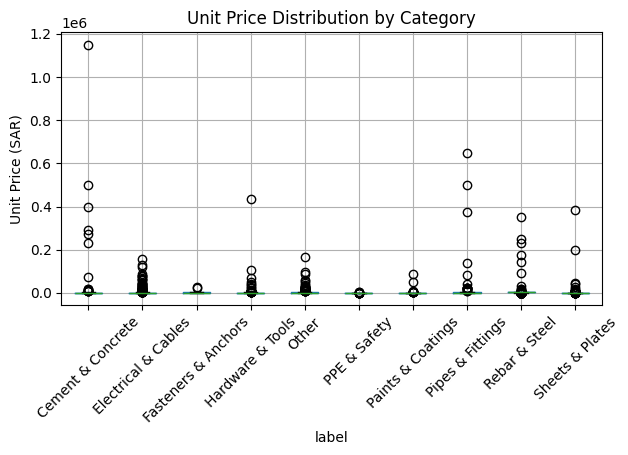

In [24]:
plt.figure(figsize=(12,6))
out.boxplot(column="Unit Price", by="label", rot=45)
plt.title("Unit Price Distribution by Category")
plt.suptitle("")
plt.ylabel("Unit Price (SAR)")
plt.tight_layout()
plt.show()